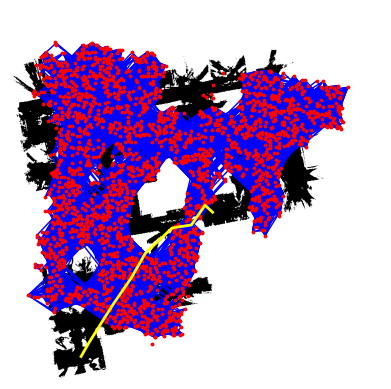

Computed Path Length: 419.7279869056281


In [3]:
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
import imageio.v2 as io

def get_free_cell(grid):
    """Selects a random free cell (non-obstacle) from the occupancy grid."""
    free_cells = list(zip(*np.where(grid == 1)))  # Find all free cells
    return random.choice(free_cells)  # Randomly choose one

def is_path_clear(grid, start, end):
    """Checks if the straight-line path between two points is obstacle-free."""
    r1, c1 = start
    r2, c2 = end
    
    # Check along the most dominant axis
    if abs(c2 - c1) > abs(r2 - r1):
        for c in np.linspace(c1, c2, num=abs(c2 - c1) + 1, dtype=int):
            if grid[r1, c] == 0:  # Encountered an obstacle
                return False
    else:
        for r in np.linspace(r1, r2, num=abs(r2 - r1) + 1, dtype=int):
            if grid[r, c1] == 0:  # Encountered an obstacle
                return False
    return True

def euclidean_distance(a, b):
    """Computes the Euclidean distance between two points."""
    return np.linalg.norm(np.array(a) - np.array(b))

def build_prm(grid, samples, radius):
    """Constructs a Probabilistic Roadmap (PRM) by sampling free space and connecting neighbors."""
    graph = nx.Graph()
    
    # Generate random nodes in free space
    for _ in range(samples):
        node = get_free_cell(grid)
        graph.add_node(node)
        
        # Connect to nearby nodes within radius
        for existing_node in graph.nodes:
            if node != existing_node and euclidean_distance(node, existing_node) <= radius:
                if is_path_clear(grid, node, existing_node):
                    graph.add_edge(node, existing_node, weight=euclidean_distance(node, existing_node))
    
    return graph

def visualize(grid, graph, path=None):
    """Displays the occupancy grid, PRM nodes and edges, and the computed path."""
    plt.imshow(grid, cmap='Greys')  # Show the occupancy grid
    positions = {node: node for node in graph.nodes}
    nx.draw(graph, pos=positions, node_size=3, node_color='red', edge_color='blue')  # Draw PRM
    
    # Plot the shortest path if available
    if path:
        path_x = [p[1] for p in path]
        path_y = [p[0] for p in path]
        plt.plot(path_x, path_y, color='yellow', linewidth=2)
    
    plt.axis('off')
    plt.show()

def main():
    """Main function to execute PRM-based path planning."""
    img = io.imread('occupancy_map.png')  # Load occupancy grid image
    grid = (img > 128).astype(int)  # Convert to binary occupancy grid
    
    start, goal = (635, 140), (350, 400)  # Define start and goal points
    prm_graph = build_prm(grid, samples=2500, radius=75)  # Construct PRM
    prm_graph.add_nodes_from([start, goal])  # Add start and goal nodes to PRM
    
    # Connect start and goal nodes to nearest PRM nodes
    for node in [start, goal]:
        for neighbor in prm_graph.nodes:
            if node != neighbor and euclidean_distance(node, neighbor) <= 75:
                if is_path_clear(grid, node, neighbor):
                    prm_graph.add_edge(node, neighbor, weight=euclidean_distance(node, neighbor))
    
    # Find shortest path using A* search
    path = nx.astar_path(prm_graph, start, goal, heuristic=euclidean_distance, weight='weight')
    
    visualize(grid, prm_graph, path)  # Visualize PRM and path
    
    # Compute and display path length
    path_length = sum(euclidean_distance(path[i], path[i+1]) for i in range(len(path)-1))
    print(f"Computed Path Length: {path_length}")

if __name__ == "__main__":
    main()


In [ ]:
1